## Telecom Churn 

**Problem Statement**: in the telecom industry, customers have freedom to choose and shift to a large variety of service providers. The annual churn rate is as high as 15%-25% in this highly competitive market. Considering the fact the consumer retention is cheaper than consumer acquisition, the focus of most service providers is to reduce the churn rate. 

**Objective**: 
1. Identify the customers that are likely to churn
2. Identify the factors that can be used to determine a churner
3. Recommend Strategies to manage customer churn


**Metric of focus**: Recall/Sensitivity
<br><font face = tahoma, color = maroon>
The business objective focuses heavily on predicting the churners right (True Positive), since they do not want to miss out on any churners.<br>
The business would be more willing to spend some money on the non-churners than miss out on the churners. Considering this, we have decided to have recall as the key metric.

**Steps to cover:**
1. [Filtering the High-Value Customers](#high-value)
2. [Data Cleaning:](#data-cleaning)
    1. Delete columns with more than 75% null/zero values or 1 unique value
    2. Delete rows of columns with more than 75% null values
    3. Impute rows with null <10% and zero<25%
    4. Delete columns with zero values > 70%
    5. Analyse the columns with more than 50% null or zero values
        1. Delete column with null>50%
        2. Impute columns with null<1%
    6. Handle date objects:
        1. Remove null values
        2. Change format from string to int 
2. [Data Preparation](#data-preparation)
    1. Tag Churners
    2. Remove attributes of churn phase
    3. Handle data imbalance
3. [EDA](#eda-analysis)
    1. Integer analysis
    2. Float analysis
    3. Identify Outliers
    4. Outlier Treatment
    5. Look for correlations
4. [Modelling](#modelling)

   1. [PCA - identify the people who will churn](#pca)
   2. [Use evaluation metrics to identify a suitable model (logistic or tree)](#model)
5. [Recommendations & Features](#recommendation)

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import math

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Resampling
from sklearn.utils import resample

#Imputing
from sklearn.preprocessing import Imputer

#Modelling
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA

#Building stats models and getting the features' VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#RFE: need to use linear regression along with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#Metrics for the final model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
churn_data = pd.read_csv('telecom_churn_data.csv')
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


--------------------------

<a id='high-value'></a>

## Filtering the High-Value Customers

**Insight**: Since 80% of the revenue comes from the top 20% of the customers, it would make more sense for a business to focus efforts on retaining them. 

**Metric**: In case of this dataset, the customers who have recharged more than or equal to the 70th percentile of the avergae recharge amount in the good phase (month 6 & 7).

<font face = tahoma, color = maroon>
**Solution**:Considering the metric, we have divided the problem into 3 parts. <br>
1. Getting the average recharge for the month 6 and 7 <br>
2. Finding the 70th percentile value <br>
3. Filtering out customers below 70th percentile

In [4]:
# find the column names that are needed to find the average

churn_data.loc[:,churn_data.columns.str.contains('rech')==1].columns

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')

In [5]:
# finding a person's average across the 2 months

churn_data['avg_amt_6_7'] = churn_data[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)

In [6]:
#finding the overall average across the months 
threshold = churn_data[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)

# find the 70th percentile
threshold = math.ceil(threshold.quantile(0.7))
threshold

369

In [7]:
# only selecting the customers with average greater than the threshold value

churn_data_set = churn_data.loc[churn_data['avg_amt_6_7']>=threshold]

In [8]:
churn_data_set.shape
# churn_data.to_csv('hv_churn_data.csv')

(29979, 227)

--------------------
<a id='data-cleaning'></a>

## Data Cleaning

At this point, we have around 29.9K customer data across 227 columns, a lot of which are empty or null. The data cleaning process will be extensive so as to attain reliable results. 
This is divided into multiple steps:
1. Delete columns with more than 75% null/zero values or 1 unique value
2. Delete rows of columns with more than 75% null values
3. Impute rows with null <10% and zero<25%
4. Delete columns with zero values > 70%
5. Analyse the columns with more than 50% null or zero values
    1. Delete column with null>50%
    2. Impute columns with null<1%
6. Handle date objects:
    1. Remove null values
    2. Change format from string to int 

In [9]:
#create a table to analyse the unique values, percentage of null values and percentage of zero values in each column
#input-> dataset
#output-> pandas dataframe with 4 columns

def data_analysis_table(df):
    analysis = pd.DataFrame({'column_name': df.columns,
                               'percent_null': ((df.isnull().sum())/len(df)*100),
                               'percent_zero': (df.isin([0.0,0,'nan']).sum()/len(df)*100),
                               'unique_values': df.nunique()})
    return analysis

**Step 1**: 

**Issue**: the following columns would in no way help with any insights due to lack of information, therefore these columns would be deleted. 

**Solution**:

Delete the columns that have
1. More than 75% null values
2. More than 75% zero values
3. Just 1 unique value

In [10]:
# using the analysis table creating a variable that return only the columns that need to be deleted

analysis = data_analysis_table(churn_data_set)
irrelevant_col = analysis.loc[(analysis.percent_null>75) | (analysis.percent_zero>80) | (analysis.unique_values==1)]
irrelevant_col.shape

(44, 4)

In [11]:
irrelevant_col

,column_name,percent_null,percent_zero,unique_values
circle_id,circle_id,0.000000,0.000000,1
loc_og_t2o_mou,loc_og_t2o_mou,0.380266,99.619734,1
std_og_t2o_mou,std_og_t2o_mou,0.380266,99.619734,1
loc_ic_t2o_mou,loc_ic_t2o_mou,0.380266,99.619734,1
last_date_of_month_6,last_date_of_month_6,0.000000,0.000000,1
last_date_of_month_7,last_date_of_month_7,0.103406,0.000000,1
last_date_of_month_8,last_date_of_month_8,0.523700,0.000000,1
last_date_of_month_9,last_date_of_month_9,1.200841,0.000000,1
std_og_t2f_mou_6,std_og_t2f_mou_6,1.054071,82.404350,1773
std_og_t2f_mou_7,std_og_t2f_mou_7,1.010707,82.764602,1714


**Analysis**
1. While circle id may have been a useful feature, it has only 1 unique value. Therefore it would not contribute further in identifying the churners.
2. Rest of the columns, have way too many null and 0 values to add to the analysis in the future.

In [12]:
# dropping the irrelevant columns from the main dataset

churn_data_set = churn_data_set.drop(irrelevant_col.column_name, axis=1)
churn_data_set.shape

(29979, 183)

In [13]:
# dropping the irrelevant columns from the analysis dataset

analysis = analysis.drop(irrelevant_col.column_name, axis=0)

----------------------

**Step 2**

**Issue**: from the 29.9K customers, there may be a few for whom we have little to no information, therefore these customers can be deleted.

**Solution**: delete rows with more than 75% null entries

In [14]:
# finding the 75% of the total columns

thresh = churn_data_set.shape[1] * 0.75
thresh

137.25

In [15]:
# dropping rows with more than 75% null values

churn_data_set_cleaned = churn_data_set.dropna(thresh=thresh)
churn_data_set_cleaned.shape

(28255, 183)

**Time to revaluate**

Our initial clean up steps have been implemented, now we try to check the impact it have had on the dataset therefor we recreate the analysis table with the updated dataset. 

In [16]:
analysis = data_analysis_table(churn_data_set_cleaned).sort_values(by=['percent_zero'])

In [17]:
analysis.loc[~((analysis.percent_null>25) | (analysis.percent_null == 0.0))]

,column_name,percent_null,percent_zero,unique_values
date_of_last_rech_8,date_of_last_rech_8,1.008671,0.000000,31
date_of_last_rech_9,date_of_last_rech_9,1.132543,0.000000,30
date_of_last_rech_7,date_of_last_rech_7,0.201734,0.000000,31
date_of_last_rech_6,date_of_last_rech_6,0.106176,0.000000,30
offnet_mou_6,offnet_mou_6,0.145107,0.686604,21544
offnet_mou_7,offnet_mou_7,0.060166,0.700761,21812
offnet_mou_8,offnet_mou_8,0.102637,1.550168,21140
onnet_mou_7,onnet_mou_7,0.060166,1.819147,18343
loc_ic_mou_7,loc_ic_mou_7,0.060166,1.882853,18548
onnet_mou_6,onnet_mou_6,0.145107,2.059812,18117


**Step 3**

Considering the above table, we can see that there are large no.of columns have null values less than 25%. Most of which are at 1%-5%. 

Considering this, the following steps will be taken to clean the data:
1. **Imputate the rows that have:**
    1. null values < 10%
    2. zero values < 25%
    
> The enteries in this case can be easily imputated with the mean without affecting the quality of information.

2. **Delete columns with percent_zero values more than 70%**

3. **Check columns with 25%-70% zero values for their percentage of null values. Based on this, further steps would be taken.**
> This needs to be analysed to check if the zero entries are a common behaviour among customers or really skewed data.

In [18]:
# filtering columns that can be imputed

impute = analysis.loc[(analysis.percent_null<10) & 
                      (analysis.percent_zero<25) & 
                      (analysis.percent_null != 0)]
impute

,column_name,percent_null,percent_zero,unique_values
date_of_last_rech_8,date_of_last_rech_8,1.008671,0.000000,31
date_of_last_rech_9,date_of_last_rech_9,1.132543,0.000000,30
date_of_last_rech_7,date_of_last_rech_7,0.201734,0.000000,31
date_of_last_rech_6,date_of_last_rech_6,0.106176,0.000000,30
offnet_mou_6,offnet_mou_6,0.145107,0.686604,21544
offnet_mou_7,offnet_mou_7,0.060166,0.700761,21812
offnet_mou_8,offnet_mou_8,0.102637,1.550168,21140
onnet_mou_7,onnet_mou_7,0.060166,1.819147,18343
loc_ic_mou_7,loc_ic_mou_7,0.060166,1.882853,18548
onnet_mou_6,onnet_mou_6,0.145107,2.059812,18117


In [19]:
# The object columns will be handled separately 

impute = impute.drop(['date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_6','date_of_last_rech_9'],axis=0)

In [20]:
# total number of null values in the dataset

churn_data_set_cleaned.isnull().sum().sum()

687765

In [21]:
# imputing the dataset

imputer = Imputer()
churn_data_set_cleaned[impute.column_name] = imputer.fit_transform(churn_data_set_cleaned[impute.column_name])
churn_data_set_cleaned.shape

/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(28255, 183)

In [22]:
# updated null values in the dataset.

churn_data_set_cleaned.isnull().sum().sum()

684433

-----------------------
**Step 3.2**

**Issue**: the columns with zero values > 70% are skewing the dataset since it is clearly evident that those columns have more than 100 unique values. With 70% zero values, the rest of the values fit above the 75th percentile. 

**Solution**: Delete columns with percent_zero values more than 70% and have any null value

In [23]:
# columns with percent zero >70% and null value != 0

dropping = analysis[(analysis.percent_zero>70) & (analysis.percent_null!=0)]
dropping

,column_name,percent_null,percent_zero,unique_values
std_ic_t2f_mou_9,std_ic_t2f_mou_9,0.736153,72.015572,1968
std_ic_t2f_mou_7,std_ic_t2f_mou_7,0.060166,72.461511,2043
ic_others_6,ic_others_6,0.145107,72.992391,1188
std_ic_t2f_mou_8,std_ic_t2f_mou_8,0.102637,73.024243,1927
ic_others_8,ic_others_8,0.102637,73.063175,1240
std_ic_t2f_mou_6,std_ic_t2f_mou_6,0.145107,73.194125,2002
loc_og_t2c_mou_8,loc_og_t2c_mou_8,0.102637,73.466643,1709
loc_og_t2c_mou_7,loc_og_t2c_mou_7,0.060166,73.721465,1706
ic_others_9,ic_others_9,0.736153,73.944435,1282
ic_others_7,ic_others_7,0.060166,74.461157,1346


In [24]:
# dropping the columns

churn_data_set_cleaned = churn_data_set_cleaned.drop(dropping.column_name, axis=1)
churn_data_set_cleaned.shape

(28255, 155)

---------------

**Step 3.3**

Time to check the columns with percent zero > 25% and percent null > 50%

In [25]:
analysis = data_analysis_table(churn_data_set_cleaned)

In [26]:
analysis.loc[(analysis.percent_zero > 25) | (analysis.percent_null>50)]

,column_name,percent_null,percent_zero,unique_values
loc_og_t2f_mou_6,loc_og_t2f_mou_6,0.145107,46.052026,3211
loc_og_t2f_mou_7,loc_og_t2f_mou_7,0.060166,44.657583,3235
loc_og_t2f_mou_8,loc_og_t2f_mou_8,0.102637,46.745709,3103
loc_og_t2f_mou_9,loc_og_t2f_mou_9,0.736153,48.143691,3108
std_og_t2t_mou_6,std_og_t2t_mou_6,0.145107,34.999115,12193
std_og_t2t_mou_7,std_og_t2t_mou_7,0.060166,34.850469,12445
std_og_t2t_mou_8,std_og_t2t_mou_8,0.102637,38.230402,11564
std_og_t2t_mou_9,std_og_t2t_mou_9,0.736153,39.911520,11073
std_og_t2m_mou_9,std_og_t2m_mou_9,0.736153,25.599009,12382
spl_og_mou_6,spl_og_mou_6,0.145107,46.671386,2966


**Analysis**

Looking at the above table, the following steps can be taken to clean the dataset further:
1. Delete columns with percent_null > 50%
> Based on the table it is evident that most of the columns with percent_null > 50, are also ones with more than 5% zero values. These columns are removed since it would clearly indicate skewed data where more than 50% of values would be null, with another 10% covering zero and the rest 30% would cover more than 100 unique values. 

2. Impute columns with percent_null less than 1%

In [27]:
# selecting columns with percent null > 50%

delete = analysis.loc[(analysis.percent_null>=50)]
delete

,column_name,percent_null,percent_zero,unique_values
date_of_last_rech_data_6,date_of_last_rech_data_6,61.426296,0.000000,30
date_of_last_rech_data_7,date_of_last_rech_data_7,60.148646,0.000000,31
date_of_last_rech_data_8,date_of_last_rech_data_8,59.062113,0.000000,31
date_of_last_rech_data_9,date_of_last_rech_data_9,59.953990,0.000000,30
total_rech_data_6,total_rech_data_6,61.426296,0.000000,36
total_rech_data_7,total_rech_data_7,60.148646,0.000000,39
total_rech_data_8,total_rech_data_8,59.062113,0.000000,45
total_rech_data_9,total_rech_data_9,59.953990,0.000000,35
max_rech_data_6,max_rech_data_6,61.426296,0.000000,43
max_rech_data_7,max_rech_data_7,60.148646,0.000000,45


In [28]:
# deleting the columns from analysis and churn dataset

analysis = analysis.drop(delete.column_name,axis=0)
churn_data_set_cleaned = churn_data_set_cleaned.drop(delete.column_name, axis=1)

In [29]:
churn_data_set_cleaned.shape

(28255, 115)

In [30]:
# selecting columns for imputation
impute = analysis.loc[(analysis.percent_null<60) & (analysis.percent_null !=0)]

# removing the object columns - they would be handled later
impute = impute.drop(['date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_6','date_of_last_rech_9'],axis=0)
impute

,column_name,percent_null,percent_zero,unique_values
loc_og_t2f_mou_6,loc_og_t2f_mou_6,0.145107,46.052026,3211
loc_og_t2f_mou_7,loc_og_t2f_mou_7,0.060166,44.657583,3235
loc_og_t2f_mou_8,loc_og_t2f_mou_8,0.102637,46.745709,3103
loc_og_t2f_mou_9,loc_og_t2f_mou_9,0.736153,48.143691,3108
std_og_t2t_mou_6,std_og_t2t_mou_6,0.145107,34.999115,12193
std_og_t2t_mou_7,std_og_t2t_mou_7,0.060166,34.850469,12445
std_og_t2t_mou_8,std_og_t2t_mou_8,0.102637,38.230402,11564
std_og_t2t_mou_9,std_og_t2t_mou_9,0.736153,39.911520,11073
std_og_t2m_mou_9,std_og_t2m_mou_9,0.736153,25.599009,12382
spl_og_mou_6,spl_og_mou_6,0.145107,46.671386,2966


In [31]:
# total number of null values in the dataset

churn_data_set_cleaned.isnull().sum().sum()

2375

In [32]:
# imputing the values

imputer = Imputer()
churn_data_set_cleaned[impute.column_name] = imputer.fit_transform(churn_data_set_cleaned[impute.column_name])
churn_data_set_cleaned.shape

/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(28255, 115)

In [33]:
# final sum of null values in the dataset

churn_data_set_cleaned.isnull().sum().sum()

692

The dataset is relatively clean now. The number of null values have been brought down from more than 6,80,000 to 692. 

The next step is to convert the date objects to integers. After the conversion the null rows can be deleted. That should cover up the 692 remaining null vlaues in the dataset.

#### Handling Date Objects

For analysis in PCA and other modelling technique, the object data types need to be converted. They can be simply converted from date string to int by just selecting the day of the month. 
The steps in this include:
1. Deleting null values
2. Data type conversion

In [34]:
# Selecting the object columns from the dataset

objects = churn_data_set_cleaned.select_dtypes('O')
objects.date_of_last_rech_7.unique()

array(['7/31/2014', '7/22/2014', '7/30/2014', '7/17/2014', '7/28/2014',
       '7/23/2014', '7/26/2014', '7/29/2014', '7/25/2014', '7/27/2014',
       '7/19/2014', '7/20/2014', '7/24/2014', '7/15/2014', '7/9/2014',
       '7/13/2014', '7/18/2014', '7/21/2014', nan, '7/16/2014',
       '7/12/2014', '7/7/2014', '7/10/2014', '7/1/2014', '7/14/2014',
       '7/6/2014', '7/11/2014', '7/8/2014', '7/2/2014', '7/4/2014',
       '7/3/2014', '7/5/2014'], dtype=object)

In [35]:
# Deleting the nan values
churn_data_set_cleaned = churn_data_set_cleaned.dropna(subset=objects.columns)

# counting the null values in the dataset
churn_data_set_cleaned.isnull().sum().sum()

0

**No more null values** 👏🏼

The null values in the dataset have been brought down to zero. Last step remaining for the cleaning is to convert the date object to string. 

In [36]:
churn_data_set_cleaned['day_of_last_rech_6'] = (pd.to_datetime(churn_data_set_cleaned['date_of_last_rech_6'], format='%m/%d/%Y')).dt.day
churn_data_set_cleaned['day_of_last_rech_7'] = (pd.to_datetime(churn_data_set_cleaned['date_of_last_rech_7'], format='%m/%d/%Y')).dt.day
churn_data_set_cleaned['day_of_last_rech_8'] = (pd.to_datetime(churn_data_set_cleaned['date_of_last_rech_8'], format='%m/%d/%Y')).dt.day
churn_data_set_cleaned['day_of_last_rech_9'] = (pd.to_datetime(churn_data_set_cleaned['date_of_last_rech_9'], format='%m/%d/%Y')).dt.day

In [37]:
# checking the data type of the new columns

churn_data_set_cleaned['day_of_last_rech_9'].dtype

dtype('int64')

In [38]:
# dropping the date columns

churn = churn_data_set_cleaned.drop(objects.columns, axis=1)

In [39]:
churn.shape

(27644, 115)

In [40]:
# we now have all columns in int64 or float64

churn.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

**Data Cleaning Evaluation**

In the data cleaning process we have achieved a clean dataset:
1. with no null values
2. with all columns in the int or float format
3. with the column count being brought down to 115 from 227
4. with fewer unnecessary rows

--------------------------
<a id='data-preparation'></a>

## Data Preparation

**Tag Churners**

Churners can be identified using the activity in the 9th month. A person have churned if:
1. Total incoming minute of use is 0
2. Total outgoing minutes of use is 0
3. 2G data use is 0
4. 3G data use is 0

Using these identifiers the churners will be tagged.

In [41]:
# tagging the churners

churn['churn'] = churn.apply(lambda x: 1 if ((x['total_ic_mou_9']==0.0)
                                                       &(x['total_og_mou_9']==0.0)
                                                       & (x['vol_2g_mb_9']==0.0)
                                                       & (x['vol_3g_mb_9']==0.0)
                                                      ) else 0, axis=1)

**Removing the attributes**

Now that we have tagged the churners, we must remove all the data relevant to the 9th month since by then the customers have already churned.

In [42]:
# removing the columns ending with 9

churn = churn.loc[:, ~churn.columns.str.contains('_9$')]

In [43]:
churn.shape

(27644, 89)

**Balance the dataset**

Obviously the no.of churners are way less than the no.of non-churners, however the imbalance between the 2 is too high for us to get reliable results in modelling. For this reason the data will be resample to make a ratio of 20:80 of churners:non churners.

We realise that the rows count comes down to 5K from 27K, however a more balanced dataset is more effective than a highly imbalanced one. 

In [44]:
df_majority = churn[churn["churn"]==0]
df_minority = churn[churn["churn"]==1]
print("Total customers not churned", len(df_majority))
print("Total customers churned",len(df_minority))

Total customers not churned 26570
Total customers churned 1074


In [45]:
#Using simple ratio method to balance the dataset to a 80:20 ratio for non-churners:churners
#   20: 80
# 1074: x
# Therefore using cross multiplication
# df_majority_count = (1074 (df_minority) * 80 ) / 20

df_majority_count = int((len(df_minority)*80)/20)
df_majority_count

4296

In [46]:
# dataset being downsampled

df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=df_majority_count,    
                                 random_state=123)
churn = pd.concat([df_majority_downsampled, df_minority])

In [47]:
churn.churn.value_counts()

0    4296
1    1074
Name: churn, dtype: int64

In [48]:
# balanced dataset

churn.shape

(5370, 89)

-----------------------------------
<a id='eda-analysis'></a>

## EDA Analysis

Now that the dataset is clean and ready, it is time to analyse the columns to look for any patterns and outliers. 
Before we move on to PCA, the dataset should be clear of outliers. 

**Analysing Integers**

In [49]:
# selecting integers

integers = churn.select_dtypes('int64')
integers.shape

(5370, 19)

In [50]:
integers.describe()

,mobile_number,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,sachet_2g_8,aon,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,churn
count,5.370000e+03,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,7.001196e+09,12.365922,12.271695,10.257542,714.930168,711.516015,609.911918,166.924953,168.826071,160.552328,101.075791,100.305028,91.963128,0.606518,1232.745251,27.012291,27.652514,26.843389,0.200000
std,6.886573e+05,9.377356,9.571355,9.306687,580.341180,595.600442,627.778936,166.044133,171.866389,180.058350,133.147764,135.596399,156.559574,1.899779,955.950133,3.987249,4.100243,4.949725,0.400037
min,7.000000e+09,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181.000000,2.000000,1.000000,1.000000,0.000000
25%,7.000597e+09,7.000000,6.000000,4.000000,440.000000,430.000000,298.000000,110.000000,110.000000,65.000000,30.000000,27.000000,0.000000,0.000000,481.000000,26.000000,26.000000,25.000000,0.000000
50%,7.001186e+09,10.000000,10.000000,8.000000,592.000000,588.000000,510.000000,110.000000,128.000000,130.000000,110.000000,86.000000,50.000000,0.000000,890.500000,28.000000,29.000000,28.000000,0.000000
75%,7.001794e+09,15.000000,15.000000,13.000000,846.000000,848.000000,777.000000,198.000000,198.000000,179.000000,110.000000,130.000000,130.000000,0.000000,1781.000000,30.000000,31.000000,30.000000,0.000000
max,7.002410e+09,125.000000,107.000000,127.000000,18500.000000,19204.000000,20405.000000,3000.000000,3100.000000,4449.000000,2933.000000,3100.000000,4449.000000,44.000000,4192.000000,30.000000,31.000000,31.000000,1.000000


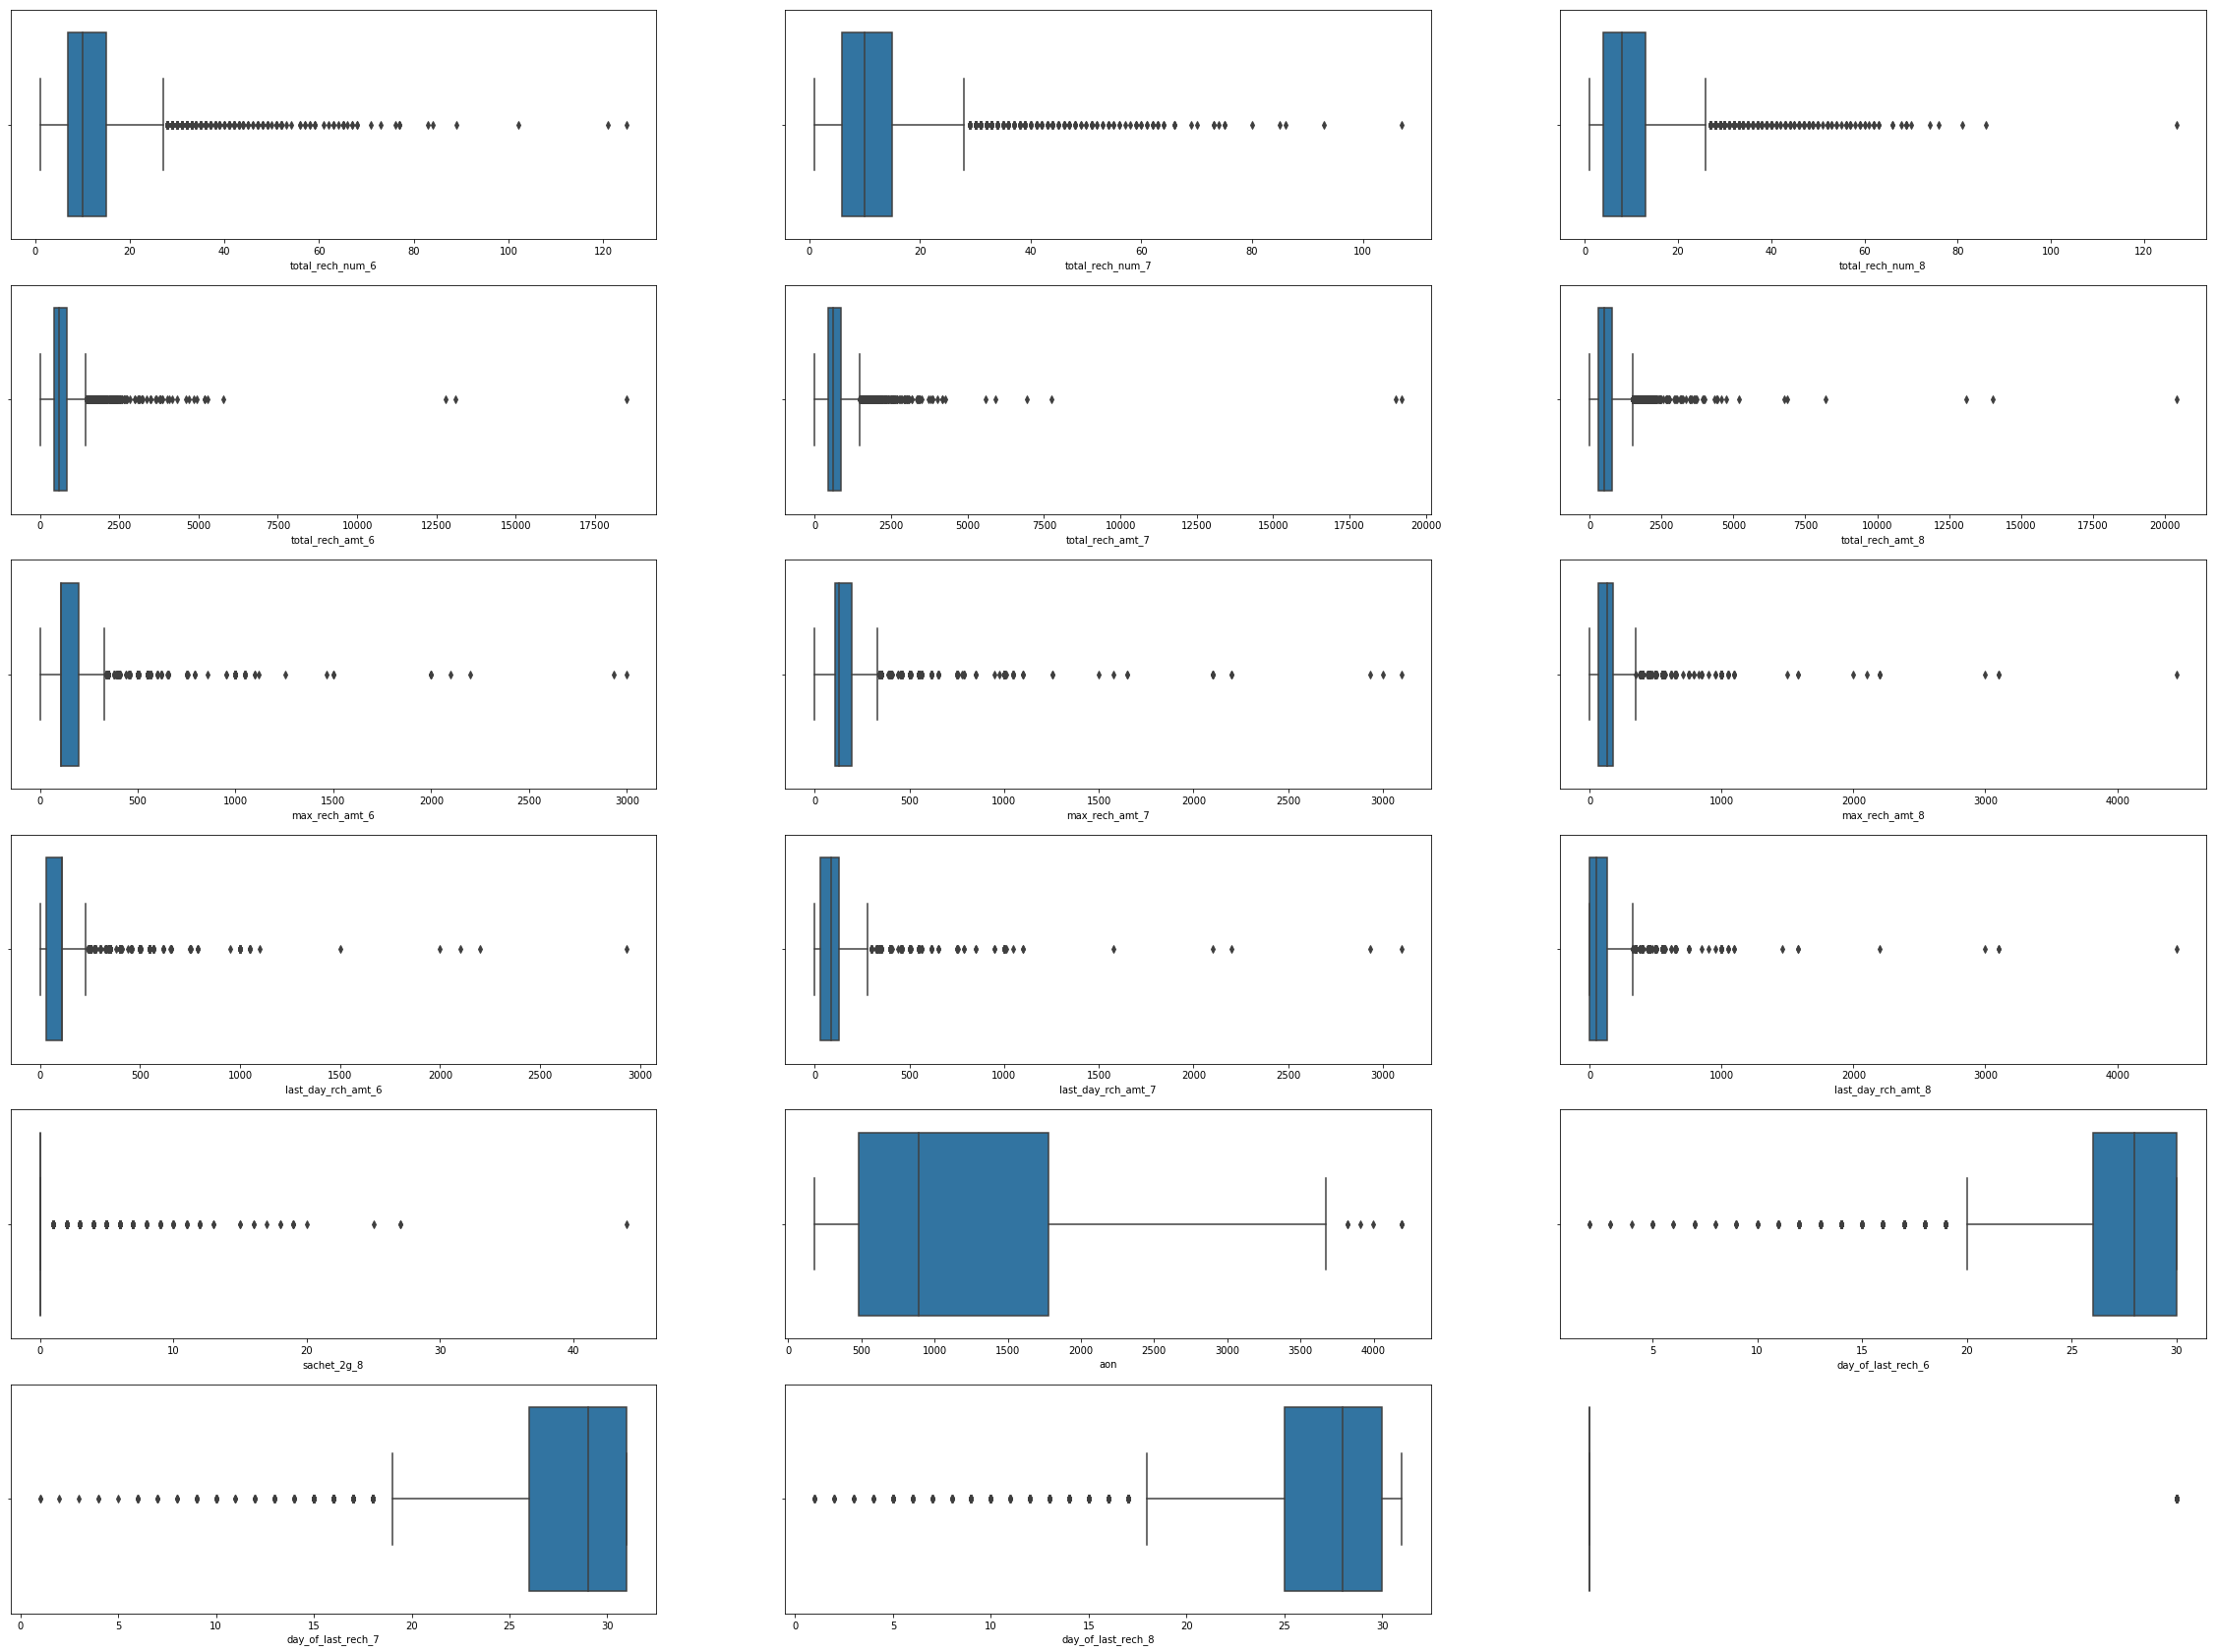

In [51]:
plot = integers
if 'mobile_number' in plot.columns:
    plot = plot.drop('mobile_number',axis=1)
fig, axs = plt.subplots(6,3, figsize=(40,30))
ax_iter = iter(axs.flat)
for i in range(18):
    ax = next(ax_iter)
    sns.boxplot(x=plot.iloc[:,i], ax=ax)
axs[-1, -1].axis('off')
plt.show()

**Analysis**

The plots and the summary clearly indicate that 
1. There are outliers in most of the columns
2. A general pattern can be noticed in the day of recharge across the 3 months. People tend to recharge their phones at the end of the month, largely between 25-30. 

In [52]:
integers = integers.drop(['mobile_number','churn','day_of_last_rech_6',
                          'day_of_last_rech_7','day_of_last_rech_8'
                         ],axis=1)

**Identifying outliers using IQR**

The method used here is as follows:
1. Find the percentile values at 25% and 90%
2. Calculate the IQR by subtracting the the percentiles calculated earlier
3. Using the standard treatment of considering the values that are 1.5 times greater than the IQR will be considered outliers
4. The outlier values will be deleted

In [53]:
# getting the quartile values

q1_int = integers.quantile(0.25)
q3_int = integers.quantile(0.90)
iqr_int = q3_int - q1_int

In [54]:
# no.of outliers

((integers < (q1_int - 1.5 * iqr_int)) | (integers > (q3_int + 1.5 * iqr_int))).sum().sum()

1312

In [55]:
data = churn.copy()

In [56]:
# removing the outliers

data = data[~((integers < (q1_int - 1.5 * iqr_int)) | (integers > (q3_int + 1.5 * iqr_int))).any(axis=1)]
data.shape

(4747, 89)

**Analysing Floats**

In [57]:
floats = churn.select_dtypes('float64')
floats.shape
floats.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,...,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_amt_6_7
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,...,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,601.800459,604.435479,531.093930,314.618453,313.207525,260.215539,440.040642,443.360832,372.117304,90.911198,...,87.966957,87.465771,72.982140,244.055190,256.433644,233.173870,118.318413,127.485276,115.312836,713.223091
std,462.856347,467.883428,549.723491,482.446653,488.858894,438.016100,504.067240,509.907174,472.136546,237.861819,...,316.163719,332.037597,326.392455,827.833184,794.716494,736.337906,347.705697,391.350114,394.186964,540.278458
min,-185.043000,-275.799000,-345.129000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,369.000000
25%,369.753250,368.247500,278.780500,44.380000,45.522500,26.565000,137.760000,138.552500,86.267500,7.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,453.500000
50%,500.898500,500.086500,442.074500,138.900000,136.310000,99.645000,291.185000,292.460000,237.110000,29.885000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,577.000000
75%,705.309750,713.401500,659.646000,387.795000,372.937500,290.607500,552.800000,561.555000,481.087500,86.575000,...,15.095000,14.962500,6.562500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,810.000000
max,11261.349000,16820.145000,19295.904000,7011.110000,8157.780000,5193.660000,8362.360000,7043.980000,7857.780000,6093.340000,...,7213.060000,7873.550000,11117.610000,20304.270000,15115.510000,14633.040000,4282.150000,5942.890000,6931.810000,18750.000000


#### *** There are a few columns with min, 25,50,75 all being zero. These columns can be deleted***

In [58]:
# dropping columns where it is seen that the the values are zero for min, 25%, 50% and 75%

churn = churn.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8',
                    'vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                    'aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'
                   ], axis=1)

In [59]:
churn.shape

(5370, 80)

**Identifying outliers using IQR**

Following similar steps as in integers

In [60]:
# getting columns with float data type

floats = churn.select_dtypes('float64')
floats.shape

(5370, 61)

In [61]:
# calculating the quartiles

q1 = floats.quantile(0.25)
q3 = floats.quantile(0.90)
iqr = q3 - q1

In [62]:
# total no.of outliers

((floats < (q1 - 1.5 * iqr)) | (floats > (q3 + 1.5 * iqr))).sum().sum()

6714

In [63]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# deleting the outliers
data = data[~((floats < (q1 - 1.5 * iqr)) | (floats > (q3 + 1.5 * iqr))).any(axis=1)]
data.shape

(3119, 89)

In [64]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_2g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_amt_6_7,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,churn
488,7002285218,324.110,515.489,494.262,51.16,86.03,88.29,183.19,231.91,220.96,...,0,495,196.01,311.98,464.8,518.5,25,28,28,0
23441,7000437805,655.006,532.711,660.864,228.13,128.13,273.91,1225.94,932.18,1311.29,...,0,501,0.00,0.00,0.0,683.0,29,30,31,0
62236,7000347138,402.060,311.234,418.606,60.71,41.63,146.03,519.13,318.91,497.78,...,0,483,0.00,0.00,0.0,444.0,28,28,28,0
68376,7001924576,326.298,343.179,425.726,67.99,238.13,179.83,157.16,402.63,600.34,...,4,908,0.00,0.00,0.0,385.0,29,31,29,0
42614,7002035534,475.592,372.801,273.940,58.51,43.51,37.31,406.61,256.99,80.79,...,1,327,0.00,0.00,0.0,491.0,28,31,29,0


In [65]:
corr = data.corr()
corr.style.background_gradient(cmap='Blues')

**Analysis**
The correlation matrix clearly indicates that there is multicollinearity which supports the need to use PCA. 

* PCA works well and should be used when there is high multicollinearity

--------------------------

<a id='modelling'></a>

## Modelling:

This section helps fulfil the objectives of identify the possible churners as well as the factors that indicate that a person will churn. This is done by the using the 2 techniques:
1. [PCA: to identify people who will churn](#pca)
2. [Logistic/Tree Model: to identify the factors that indicate churn](#model)
    1. RFE
    2. Manual Feature Selection
    
--------------------------

**Initial Steps**
1. Train_Test_Split
2. Standardise Dataset
3. Make mobile number the index - this would make it easier in the end to identify the users that are likely to churn.

In [66]:
churn_pca = data.copy()
churn_pca.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_2g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_amt_6_7,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,churn
488,7002285218,324.110,515.489,494.262,51.16,86.03,88.29,183.19,231.91,220.96,...,0,495,196.01,311.98,464.8,518.5,25,28,28,0
23441,7000437805,655.006,532.711,660.864,228.13,128.13,273.91,1225.94,932.18,1311.29,...,0,501,0.00,0.00,0.0,683.0,29,30,31,0
62236,7000347138,402.060,311.234,418.606,60.71,41.63,146.03,519.13,318.91,497.78,...,0,483,0.00,0.00,0.0,444.0,28,28,28,0
68376,7001924576,326.298,343.179,425.726,67.99,238.13,179.83,157.16,402.63,600.34,...,4,908,0.00,0.00,0.0,385.0,29,31,29,0
42614,7002035534,475.592,372.801,273.940,58.51,43.51,37.31,406.61,256.99,80.79,...,1,327,0.00,0.00,0.0,491.0,28,31,29,0


In [67]:
# Train and Test Split

X = churn_pca.drop(['churn'], axis = 1)
y = churn_pca[['churn','mobile_number']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [68]:
# Standardisation
scaler = StandardScaler()

# Fit on training set only.
X_train.loc[:,~X_train.columns.isin(['mobile_number'])] = scaler.fit_transform(X_train.loc[:,~X_train.columns.isin(['mobile_number'])])

# Apply transform to both the training set and the test set.
X_test.loc[:,~X_test.columns.isin(['mobile_number'])] = scaler.transform(X_test.loc[:,~X_test.columns.isin(['mobile_number'])])

In [69]:
X_train.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,vol_3g_mb_8,sachet_2g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_amt_6_7,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
60375,7001864552,-0.316614,0.056689,0.144360,-0.732027,-0.679926,-0.480670,-0.190261,0.179946,0.179850,...,-0.347614,3.466112,-0.569402,-0.321235,-0.320101,-0.296859,-0.389461,-0.016305,-2.636760,0.273173
89816,7001078779,-0.438875,-1.060223,0.080023,0.226798,-0.633803,-0.047786,-0.131647,-0.488269,0.737028,...,-0.347614,3.466112,2.388501,-0.321235,-0.320101,-0.296859,-0.925291,0.774674,0.613831,0.474299
21350,7001067004,-0.436995,0.231837,-0.260952,1.949588,3.607183,3.176538,-0.587964,-0.796261,-0.974721,...,-0.347614,-0.379643,-0.864341,-0.321235,-0.320101,-0.296859,0.008977,0.511014,-0.136305,0.474299
83083,7000800685,0.367894,0.230063,-0.744713,-0.531422,0.212037,-0.687585,1.045460,0.204906,-0.457756,...,-0.347614,-0.379643,0.345227,-0.321235,-0.320101,-0.296859,0.350168,0.511014,0.613831,0.876550
46266,7000604624,0.127399,0.452491,-0.211123,-0.038887,0.090339,-0.144021,0.711849,0.972652,0.677558,...,-0.347614,0.581796,0.476192,-0.321235,-0.320101,-0.296859,0.537937,0.511014,0.863877,0.675424


In [70]:
X_train.set_index('mobile_number',inplace=True)
X_test.set_index('mobile_number',inplace=True)
y_train.set_index('mobile_number',inplace=True)
y_test.set_index('mobile_number',inplace=True)

<a id='pca'></a>

## Identifying the people who are likely to churn using PCA

**Steps:**

1. Fit pca to X_train
2. Use the explained_variance_ratio_ to identify the optimum no.of components needed
3. Check ROC_AUC_Score
4. Use a correlation matrix to check for multicollinearity
5. Run the model on the test set
6. Find the optimum threshold

In [71]:
# fitting pca to X_train

from sklearn.decomposition import PCA
pca = PCA(svd_solver = 'randomized', random_state = 42)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [72]:
pca.components_

array([[ 3.14516654e-02,  5.28598620e-02,  9.75005212e-02, ...,
        -2.34885774e-02, -6.76754865e-04,  1.03112691e-02],
       [ 8.90251901e-02,  1.45252653e-01,  1.28552901e-01, ...,
         9.51695927e-02,  9.22941287e-02,  9.45226409e-02],
       [ 8.35830352e-02,  2.16461162e-01,  2.27988496e-01, ...,
        -8.98658038e-02, -1.85467379e-03, -9.46909712e-03],
       ...,
       [ 2.44122526e-06, -2.31803705e-07, -2.82160482e-06, ...,
        -2.90037940e-07, -3.97907250e-07, -2.52014689e-07],
       [-1.62088963e-06, -1.01401442e-06, -2.09095887e-06, ...,
         1.15475139e-07, -7.70928145e-07, -1.58791368e-07],
       [-3.83029161e-16,  5.45021308e-16, -5.77836128e-17, ...,
        -5.84154952e-17, -2.53272807e-19, -1.02663960e-16]])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

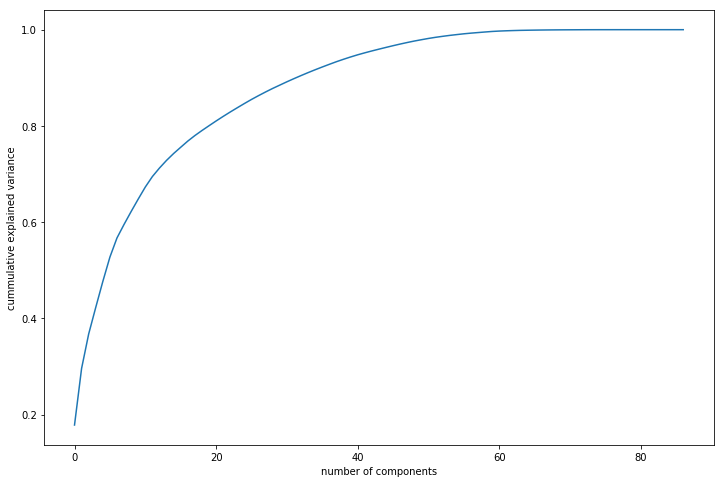

In [73]:
# plotting the graph for cummulative variance across different components

fig = plt.figure(figsize = (12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cummulative explained variance')
plt.plot

**Analysis**

The above graph clearly indicates that from 60 onwards there is no major increase in the cummulative explained variance. On the other hand it is seen that the curve is steep and fast growing from 0-20, which further slows down from 20-40. 

This shows that our optimum number of components is where higher variance is explained by fewer components, this seems to lie between 20-40.  

To be certain of this, the expected cummulative variance will be given as input to get the corresponding no.of components. Aim is to find fewer no.of components that explain more than or equal to 80% of the variance. 

In [74]:
def predict_with_percentage(percentage,X_train,y_train,X_test):
    pca_auto = PCA(percentage)

    # Apply PCA on X_train
    df_train_pca = pca_auto.fit_transform(X_train)
    print('Train set shape',df_train_pca.shape)

    lr = LogisticRegression()
    model_pca_auto = lr.fit(df_train_pca, y_train)

    # Apply on X_test
    df_test_pca_auto = pca_auto.transform(X_test)
    print('Test set shape',df_test_pca_auto.shape)

    # Making predictions on the Test data
    pred_prob_pca_auto_test = model_pca_auto.predict_proba(df_test_pca_auto)[:, 1]
    score = "{:2.2f}".format(metrics.roc_auc_score(y_test, pred_prob_pca_auto_test))
    print('ROC_AUC_Score:',score)
    
    return df_test_pca_auto

In [75]:
def corr_matrix(df):
    #creating correlation matrix for the principal components
    corrmat = np.corrcoef(df.transpose())

    #plotting the correlation matrix
    %matplotlib inline
    plt.figure(figsize = (20,10))
    sns.heatmap(corrmat, cmap='summer', annot = True)

In [76]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
pca_90 = predict_with_percentage(0.9,X_train,y_train,X_test)

Train set shape (2183, 33)
Test set shape (936, 33)
ROC_AUC_Score: 0.90


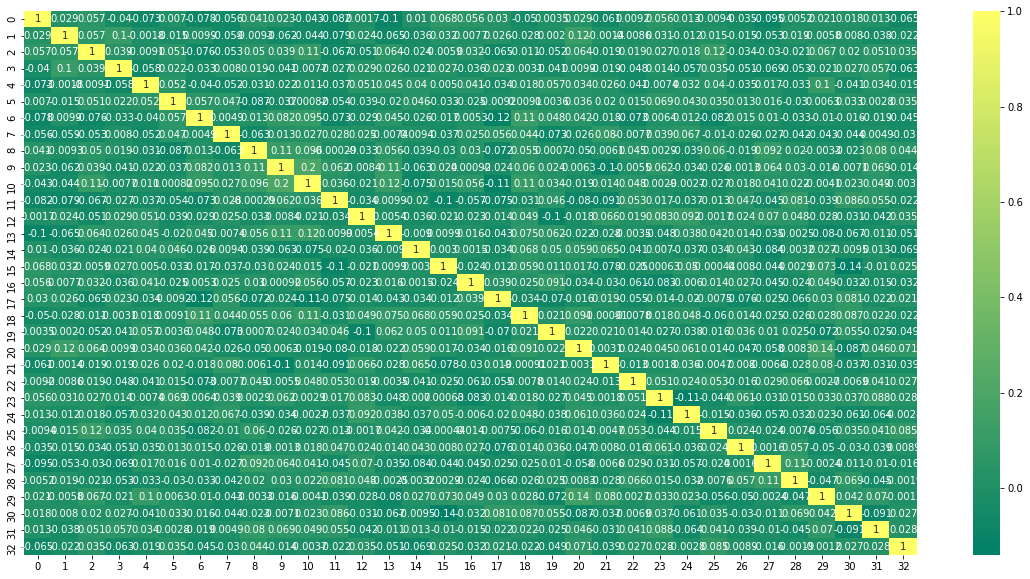

In [77]:
corr_matrix(pca_90)

Train set shape (2183, 26)
Test set shape (936, 26)
ROC_AUC_Score: 0.90


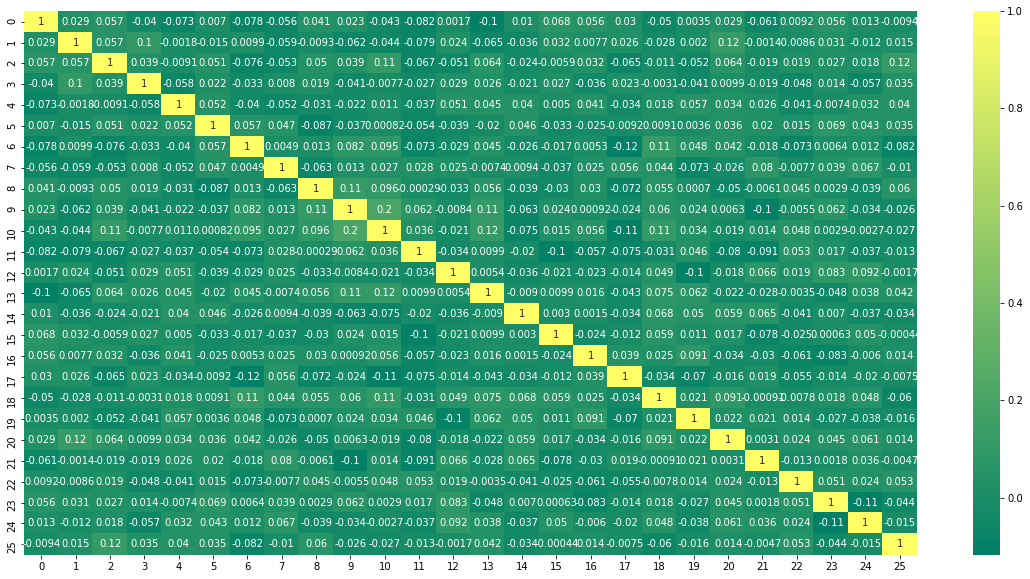

In [78]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pca_85 = predict_with_percentage(0.85,X_train,y_train,X_test)
corr_matrix(pca_85)

Train set shape (2183, 20)
Test set shape (936, 20)
ROC_AUC_Score: 0.90


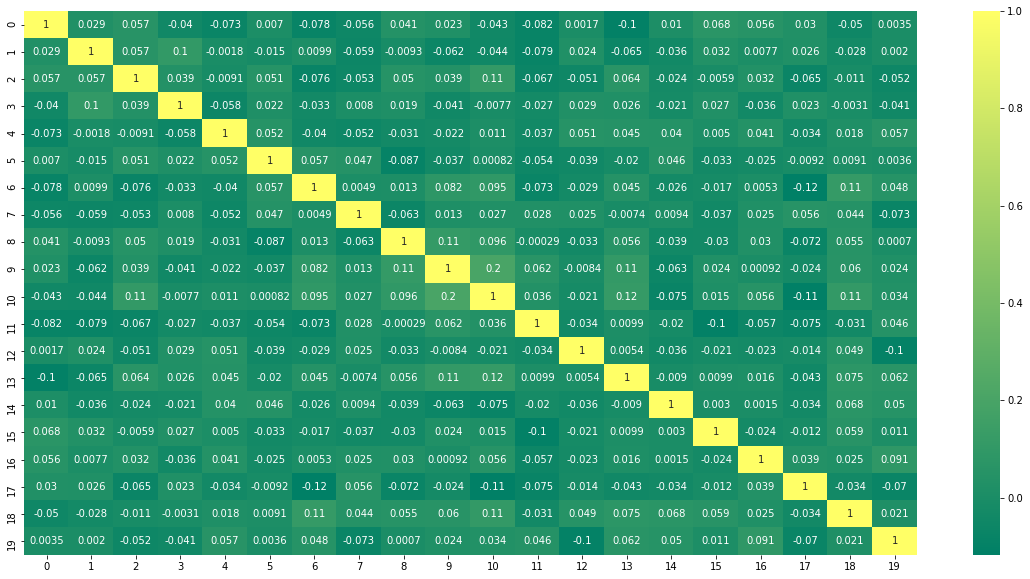

In [79]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pca_80 = predict_with_percentage(0.8,X_train,y_train,X_test)
corr_matrix(pca_80)

Train set shape (2183, 6)
Test set shape (936, 6)
ROC_AUC_Score: 0.86


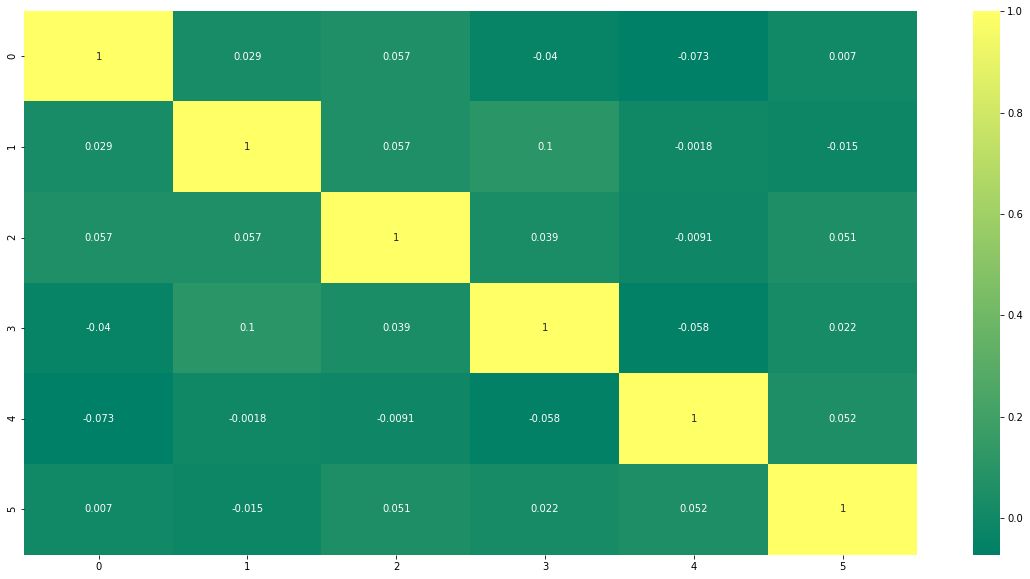

In [80]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
pca_50 = predict_with_percentage(0.5,X_train,y_train,X_test)
corr_matrix(pca_50)

**Analysis**

As seen from the range of cummulative frequencies, 0.8 with 20 components seems to be the most effective one.
While 0.85 and 0.9 explain greater variance in the dataset and have a good accuracy, the need more components. At 0.8, the ROC_AUC_Score is more or less the same and it has fewer features too.

Also, from the pca with 0.5 cummulative frequency, it has brought down the components to a great extent but that has compromised on the cummulative variance ratio, which will affect the other metrics. 

> Cummulative Variance: 0.8 
> No.of Components: 20

In [81]:
# Set PCA cummulative variance percentages will automatically get us the no of PCA components to get to this PCA cummulative variance percentage
pca_auto = PCA(0.8)

# Apply PCA on X_train
df_train_pca_auto = pca_auto.fit_transform(X_train)
df_train_pca_auto.shape                             

# Using StatsModel API
logm = sm.GLM(y_train,(sm.add_constant(df_train_pca_auto)), family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2162
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -772.82
Date:                Mon, 19 Aug 2019   Deviance:                       1545.6
Time:                        21:22:30   Pearson chi2:                 4.34e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0385      0.097    -20.911      0.000      -2.230      -1.847
x1            -0.4298      0.030    -14.096      0.000      -0.490      -0.370
x2            -0.0337      0.021     -1.570      0.116      -0.076       0.008
x3            -0.1604      0.032     -4.956      0.000      -0.224      -0.097
x4             0.1105      0.029      3.811      0.000       0.054       0.167
x5             0.4164      0.032     13.110      0.000       0.354       0.479
x6             0.0132      0.035      0.378      0.705      -0.055       0.082
x7            -0.1066      0.038     -2.788      0.005      -0.182      -0.032
x8             0.2583      0.047      5.494      0.000       0.166       0.350
x9            -0.2285      0.057     -3.999      0.000      -0.340      -0.117
x10            0.1461      0.054      2.708      0.007       0.040       0.252
x11            0.0018      0.057      0.030      0.976      -0.111       0.114
x12           -0.0040      0.073     -0.055      0.956      -0.148       0.140
x13            0.2632      0.059      4.428      0.000       0.147       0.380
x14           -0.0924      0.063     -1.474      0.140      -0.215       0.030
x15           -0.0285      0.067     -0.425      0.671      -0.160       0.103
x16            0.0239      0.089      0.268      0.789      -0.151       0.198
x17           -0.2340      0.066     -3.571      0.000      -0.362      -0.106
x18           -0.0824      0.069     -1.194      0.233      -0.218       0.053
x19           -0.0519      0.078     -0.661      0.509      -0.206       0.102
x20           -0.0784      0.073     -1.070      0.285      -0.222       0.065
==============================================================================
"""

## Visualisations

**2D Visualisation**

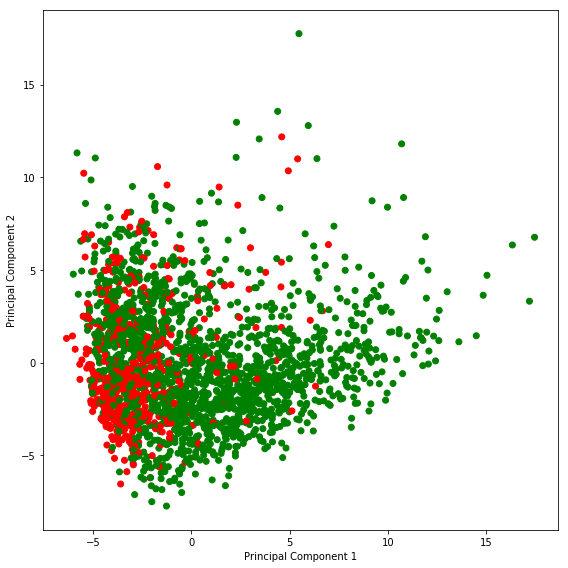

In [82]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca_auto[:,0], df_train_pca_auto[:,1], c = y_train['churn'].map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

**3D Visualisation**

<br>
<font face = tahoma, color = maroon>
The 2D representation does not clearly distinguish the classes and the shape, hence we draw a 3D graph. <br>
We can clearly see the concentration of the two classes and the fact that 20 PCA components capture a good amount of variance in the dataset.
</font>

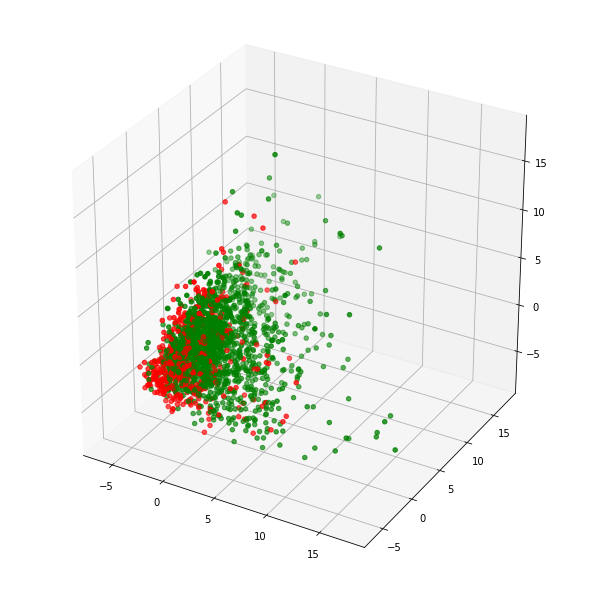

In [83]:
%matplotlib notebook
%matplotlib inline


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
# ax = plt.axes(projection='3d')
ax.scatter(df_train_pca_auto[:,2], df_train_pca_auto[:,0], df_train_pca_auto[:,1], c=y_train['churn'].map({0:'green',1:'red'}))

**Building the model**

In [84]:
pca_last = PCA(n_components=20)
df_train_pca3 = pca_last.fit_transform(X_train)
df_test_pca3 = pca_last.transform(X_test)
df_test_pca3.shape

(936, 20)

In [85]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# training the regression model
learner_pca3 = LogisticRegression()
model_pca3 = learner_pca3.fit(df_train_pca3,y_train)

# Making prediction on the test data
pred_probs_test3 = model_pca3.predict_proba(df_test_pca3)[:,1]
#"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test3))



## Getting the predictions

Creating the confusion matrix and comparing the predicted values with actual values

In [86]:
#create a table for easy and quick comparision between the predicted values and actual values
def create_table(pred, actual, index):
    churner_pred = pd.DataFrame(pred)
    churner = pd.DataFrame(actual)
    churner[index] = actual.index
    churner_pred.reset_index(drop=True, inplace=True)
    churner.reset_index(drop=True, inplace=True)
#     Appending churners_pred and churners
    churn_final = pd.concat([churner,churner_pred],axis=1)
    # Renaming the column 
    churn_final= churn_final.rename(columns={ churn_final.columns[2] : 'Churn_Prob'})
    # Let's see the head of y_pred_final
    return churn_final

def predictions(df,threshold):
    #Making predictions based on the probability
    df['Predicted'] = df.Churn_Prob.map( lambda x: 1 if x > threshold else 0)
    
    #Confusion Matrix
    confusion = confusion_matrix(df.churn, df.Predicted )
    print('Confusion Matrix \n',confusion)
    
    return confusion


def metrics(cm,df):
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    accuracy = accuracy_score(df.churn, df.Predicted)
    specificity = TN / float(TN+FP)
    sensitivity = TP / float(TP+FN)
    print('Accuracy: ', accuracy)
    print('Specificity: ',specificity)
    print('Sensitivity:',sensitivity)
    return None

In [87]:
churn_cm = create_table(pred_probs_test3,y_test, 'Mobile_Number')
churn_cm.head()

,churn,Mobile_Number,Churn_Prob
0,0,7001630569,0.002821
1,0,7001969501,0.452265
2,0,7000204060,0.276666
3,0,7000663559,0.828323
4,0,7000984590,0.103414


In [88]:
confusion = predictions(churn_cm,0.5)

Confusion Matrix 
 [[684  43]
 [ 88 121]]


In [89]:
metrics(confusion,churn_cm)

Accuracy:  0.8600427350427351
Specificity:  0.9408528198074277
Sensitivity: 0.5789473684210527


## Finding the Optimal Threshold

In [90]:
def optimal_threshold(pred_final):
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        pred_final[i]= pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
    
    #calculating different variables
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = confusion_matrix(pred_final.churn, pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
    
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]  
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

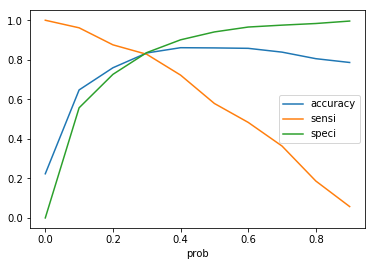

In [91]:
optimal_threshold(churn_cm)

In [92]:
churn_cm = create_table(pred_probs_test3,y_test, 'Mobile_Number')
churn_cm.head()

,churn,Mobile_Number,Churn_Prob
0,0,0,0.002821
1,0,1,0.452265
2,0,2,0.276666
3,0,3,0.828323
4,0,4,0.103414


In [93]:
confusion = predictions(churn_cm,0.3)

Confusion Matrix 
 [[608 119]
 [ 36 173]]


In [94]:
metrics(confusion,churn_cm)

Accuracy:  0.8344017094017094
Specificity:  0.8363136176066025
Sensitivity: 0.8277511961722488


In [95]:
# filter out the mobile numbers that have predicted churners as 1

churner_no = churn_cm[churn_cm.Predicted==1]
churner_no.head()

,churn,Mobile_Number,Churn_Prob,Predicted
1,0,1,0.452265,1
3,0,3,0.828323,1
5,0,5,0.409924,1
7,1,7,0.970985,1
11,0,11,0.512961,1


**Analysis & Evaluation**

In the PCA section, we have successfully:
1. Brought down the relevant features down from 86 to 20 components without much loss of information
2. Created a model that gives more than 80% result for the 3 metrics (accuracy, sensitivity and specificity
3. Found the method by which the mobile numbers can be identified of the churners.

<a id='model'></a>

## Identifying the factors that indicate churn using Logistic/Tree models

**Steps:**
1. [Model Selection](#model-selection)
2. [Hyperparameter tuning](#hyperparameter)
3. [Feature Selection](#feature-selection)
    1. RFE
    2. Manual Selection

----------------------
<a id='model-selection'></a>

## Model Selection

**Purpose**: try out a reasonable amount of models and select the best one through the key metric (recall) along with accuracy. 

**Method**: calculate the cross_val_score of different models when run on the cleaned and standardised X_train and y_train.

**Expected output**: a boxplot that shows the recall and accuracy value of the different models that is run 5 times. 

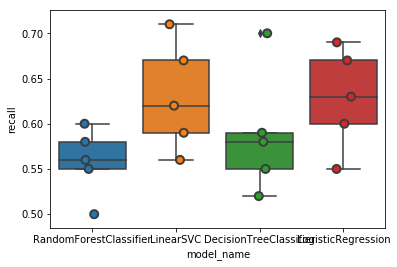

In [96]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#models to test for accuracy and recall
models = [
    RandomForestClassifier(),
    LinearSVC(),
    DecisionTreeClassifier(),
    LogisticRegression(random_state=0),
]

#CV is the number of times the same model will be tested for recall
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
#running each model for cross_val_score and appending the recall value to the cv_df dataframe
for model in models:
    model_name = model.__class__.__name__
    recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=CV)
    for fold_idx, recall in enumerate(recall):
        entries.append((model_name, fold_idx, recall))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'recall'])
    
cv_df

#plotting the box plot
%matplotlib inline
sns.boxplot(x='model_name', y='recall', data=cv_df)
sns.stripplot(x='model_name', y='recall', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

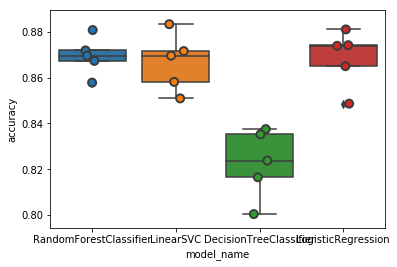

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score

# models to test for accuracy and recall
models = [
    RandomForestClassifier(),
    LinearSVC(),
    DecisionTreeClassifier(),
    LogisticRegression(random_state=0),
]

#CV is the number of times the same model will be tested for accuracy
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# running each model for cross_val_score and appending the accuracy value to the cv_df dataframe
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
cv_df

# plotting the box plot
%matplotlib inline
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

**Selection Process**

1. **Recall:** the plot for recall show that Logistic Regression and Linear SVC is doing equally well, followed by Decision Tree (with outliers) and Random Forest Regression
2. **Accuracy:** the plot shows that Random Forest, Linear SVC and Logistic Regression stand at more or less the same accuracy score.

**Model Analysis**:
1. Logistic regression: 
    1. Does not work well with high no.of features
    2. Not good with categorical variables
    3. Regularisation can help handle multi-collinearity
    4. Simpler model
2. Tree Models:
    1. Chances of overfitting
    2. Intuitive rules that make it easy to interpret
    3. Don't do well with multi-collinearity
3. SVC: 
    1. Computationally intensive and time consuming
    
Considering the above pros and cons of the different models,logistic regression and tree models seem like a good option. SVC is highly computationally intensive and time consuming therefore can be avoided in this case since Random Forest and Logistic Regression are giving good results. 

**Rule of thumb**: it states that start with a simpler model (Logistic Regression) as a baseline and then move on to Decision Tree/Random Forest to compare the difference in results. If there isn't a significant different in the results, choose the simpler model.

**Application**: considering this rule of thumb, we decide to go ahead with logitstic regression. The variation in the accuracy and recall is either minimal or Logistic Regression is performing better.


> **Model Seleted:** Logistic Regression


<a id='hyperparameter'></a>


## Hyperparameter Tuning

Since we have decided to go ahead with Logistic Regression, one thing that will need to be handled is the multicollinearity. This will be done through **regularisation**. The hyperparameter for this model will be C, we try a range of them to find the optimal amount of regularisation.

In [98]:
from sklearn.linear_model import LogisticRegression

folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of parameters (C) as a list
params = {"C":[0.001,0.01,0.1,1,10] }

model = LogisticRegression()

# setting up GridSearchCV with 5 fold CV Scheme
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                       return_train_score=True)     

In [99]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# fitting the GridSearchCV to the train sets
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [100]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.019028,0.004425,0.001322,0.000279,0.001,{'C': 0.001},0.821510,0.812357,0.800915,0.862385,...,0.819056,0.023199,5,0.828179,0.820160,0.826460,0.816256,0.826560,0.823523,0.004553
1,0.028214,0.004487,0.001298,0.000404,0.01,{'C': 0.01},0.855835,0.876430,0.864989,0.878440,...,0.867155,0.008900,1,0.872279,0.869416,0.869416,0.871780,0.873497,0.871278,0.001620
2,0.047918,0.002930,0.001065,0.000060,0.1,{'C': 0.1},0.846682,0.883295,0.867277,0.866972,...,0.866239,0.011629,3,0.885452,0.877434,0.874570,0.882656,0.876359,0.879294,0.004089
3,0.073464,0.007214,0.001251,0.000375,1,{'C': 1},0.848970,0.887872,0.862700,0.860092,...,0.867155,0.013498,1,0.887171,0.876861,0.877434,0.883228,0.880939,0.881127,0.003816
4,0.136659,0.018314,0.001005,0.000079,10,{'C': 10},0.842105,0.887872,0.867277,0.857798,...,0.864407,0.014882,4,0.886025,0.879152,0.877434,0.884946,0.879222,0.881356,0.003449


In [101]:
# getting the mean test and train score for different C values

columns = ['mean_test_score','mean_train_score','param_C']
cv_results[columns].head()

,mean_test_score,mean_train_score,param_C
0,0.819056,0.823523,0.001
1,0.867155,0.871278,0.01
2,0.866239,0.879294,0.1
3,0.867155,0.881127,1
4,0.864407,0.881356,10


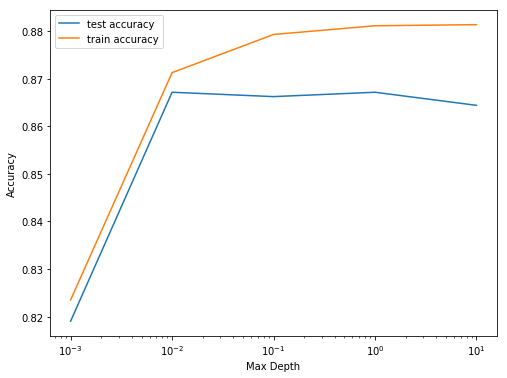

In [102]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

**Hyperparameter Selection**

Looking at the graph it is clear that **0.1** is the right value for regularisation. 

*PS: the graph has been plotted using the log scale for x-axis to get make it easier to spot a pattern.

<a id='feature-selection'></a>


## Feature Selection

Now that the model and the hyperparameter is selected, we move on to bringing down the feature count from 86 to as few as possible while maintaining a good accuracy score and also reducing multi-collinearity.

We do this in 2 steps:
1. RFE
2. Manual Selection

In [103]:
def create_model(dataset):
    # Build a fitted model
    X_train_sm = sm.add_constant(dataset)
    logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
    res = logm4.fit()
    print(res.summary())
    get_vif(dataset)
    
    return logm4
    
def get_vif(dataset):
    vif = pd.DataFrame()
    vif['Features'] = dataset.columns
    vif['VIF'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print('VIF values \n')
    print(vif)
    
def predict(model,dataset):
    y_train_pred = res.predict(dataset).values.reshape(-1)
    y_train_pred_final['Churn_Prob'] = y_train_pred
    # Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
    y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
    print(metrics.accuracy_score(y_train.Churn, y_train_pred_final.predicted))
    

In [104]:
model_1 = create_model(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2096
Model Family:                Binomial   Df Model:                           86
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -660.84
Date:                Mon, 19 Aug 2019   Deviance:                       1321.7
Time:                        21:22:41   Pearson chi2:                 1.72e+04
No. Iterations:                    10   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.5251      0.178    -14.177      0.000      -2.874      -2.176
arpu_6                 0.054

VIF values 

              Features           VIF
63    total_rech_amt_6           inf
64    total_rech_amt_7           inf
83         avg_amt_6_7           inf
20        loc_og_mou_8  1.442392e+09
19        loc_og_mou_7  1.417065e+09
18        loc_og_mou_6  1.396799e+09
47        loc_ic_mou_8  9.298717e+08
13    loc_og_t2m_mou_7  9.040794e+08
14    loc_og_t2m_mou_8  8.874115e+08
12    loc_og_t2m_mou_6  8.543921e+08
45        loc_ic_mou_6  7.717398e+08
46        loc_ic_mou_7  7.613503e+08
41    loc_ic_t2m_mou_8  5.735080e+08
40    loc_ic_t2m_mou_7  4.696305e+08
39    loc_ic_t2m_mou_6  4.592599e+08
9     loc_og_t2t_mou_6  1.834116e+08
10    loc_og_t2t_mou_7  1.655816e+08
11    loc_og_t2t_mou_8  1.618626e+08
36    loc_ic_t2t_mou_6  8.938041e+07
38    loc_ic_t2t_mou_8  8.720509e+07
37    loc_ic_t2t_mou_7  7.951630e+07
42    loc_ic_t2f_mou_6  4.092245e+06
43    loc_ic_t2f_mou_7  3.945112e+06
44    loc_ic_t2f_mou_8  3.699241e+06
16    loc_og_t2f_mou_7  1.027933e+06
15    loc_og_t2f_mou_6  9

**RFE**

Starting off by bring down the no.of features from 86 to 20.

In [105]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [106]:
logreg = LogisticRegression(C=0.1)

In [107]:
rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_train, y_train)

In [108]:
# columns selected through RFE
col = X_train.columns[rfe.support_]
col

Index(['arpu_7', 'onnet_mou_6', 'onnet_mou_8', 'offnet_mou_7', 'offnet_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2m_mou_8',
       'std_og_mou_8', 'spl_og_mou_8', 'total_og_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8'],
      dtype='object')

In [109]:
# filtering the training set to the features selected by RFE
X_train = X_train[col]

In [110]:
create_model(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2162
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -704.31
Date:                Mon, 19 Aug 2019   Deviance:                       1408.6
Time:                        21:22:46   Pearson chi2:                 2.34e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2482      0.115    -19.615      0.000      -2.473      -2.024
arpu_7                 0.275

**Manual Feature Selection**

The features will be dropped till the time all the p-values are less than 0.05 and VIF values are less than 5.

*P-values and VIF will be considered before dropping any feature.*

In [111]:
X = X_train.drop('total_og_mou_8',1)
X.shape

(2183, 19)

In [112]:
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2163
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.49
Date:                Mon, 19 Aug 2019   Deviance:                       1413.0
Time:                        21:22:46   Pearson chi2:                 2.16e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2354      0.113    -19.734      0.000      -2.457      -2.013
arpu_7                 0.269

In [113]:
X = X.drop('loc_ic_mou_8',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2164
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.50
Date:                Mon, 19 Aug 2019   Deviance:                       1413.0
Time:                        21:22:46   Pearson chi2:                 2.13e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2350      0.113    -19.734      0.000      -2.457      -2.013
arpu_7                 0.270

In [114]:
X = X.drop('std_og_t2m_mou_8',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2165
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.82
Date:                Mon, 19 Aug 2019   Deviance:                       1413.6
Time:                        21:22:46   Pearson chi2:                 2.17e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2348      0.113    -19.751      0.000      -2.457      -2.013
arpu_7                 0.273

In [115]:
X = X.drop('std_og_mou_8',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2166
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -747.29
Date:                Mon, 19 Aug 2019   Deviance:                       1494.6
Time:                        21:22:46   Pearson chi2:                 1.68e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2718      0.115    -19.698      0.000      -2.498      -2.046
arpu_7                 0.398

In [116]:
X = X.drop('loc_ic_t2m_mou_8',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2167
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -747.50
Date:                Mon, 19 Aug 2019   Deviance:                       1495.0
Time:                        21:22:46   Pearson chi2:                 1.47e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2558      0.112    -20.223      0.000      -2.474      -2.037
arpu_7                 0.398

In [117]:
X = X.drop('offnet_mou_8',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2168
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -747.70
Date:                Mon, 19 Aug 2019   Deviance:                       1495.4
Time:                        21:22:46   Pearson chi2:                 1.57e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2663      0.111    -20.447      0.000      -2.484      -2.049
arpu_7                 0.404

In [118]:
X = X.drop('loc_og_mou_7',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2169
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -748.38
Date:                Mon, 19 Aug 2019   Deviance:                       1496.8
Time:                        21:22:46   Pearson chi2:                 1.71e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2725      0.111    -20.445      0.000      -2.490      -2.055
arpu_7                 0.377

In [119]:
X = X.drop('offnet_mou_7',1)
create_model(X)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2183
Model:                            GLM   Df Residuals:                     2170
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -749.74
Date:                Mon, 19 Aug 2019   Deviance:                       1499.5
Time:                        21:22:46   Pearson chi2:                 1.79e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2735      0.111    -20.495      0.000      -2.491      -2.056
arpu_7                 0.441

**Evaluation**

1. At this point, the VIF values are all below 5 and p-values are below 0.05. 
2. The features count has come down from 20(after RFE) to 12.

We seemed to have brought down the features down to a reasonable amount and also have managed to deal with multi-collinearity as since by the VIF values. 

**Next Step**
To create a Logistic Regression Model with the selected features and regularisation value at 0.1

In [120]:
lr = LogisticRegression(C=0.1)
lr.fit(X,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

---------------

<a id='evaluation'></a>

## Evaluation

**Steps**
1. Filter the test set to have the selected features
2. Use the Logistic Regression model to predict probabilities
3. Check the metrics with 0.5 as the threshold
4. Find the optimum value for the threshold
5. Evaluate the metrics.

In [121]:
# filtering the test set to have the selected features

X_pred_test = pd.DataFrame(X_test[X.columns])
X_pred_test.head()

,arpu_7,onnet_mou_6,onnet_mou_8,loc_og_mou_6,loc_og_mou_8,spl_og_mou_8,total_ic_mou_6,total_ic_mou_8,total_rech_num_8,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8
mobile_number,,,,,,,,,,,,
7001630569,1.491784,-0.752527,-0.526096,2.230523,4.329892,0.003191,0.225005,1.016014,-0.139833,0.995722,-0.229366,-0.347614
7001969501,-2.105328,2.050550,-0.236384,-0.363524,-0.844938,-0.515516,-0.192584,-0.780144,0.009363,-0.792199,-0.229366,-0.347614
7000204060,0.592069,-0.744208,-0.712486,-0.879324,-0.857776,-0.524459,-1.123556,-0.958554,-1.184207,2.320584,-0.096628,0.312674
7000663559,-0.471265,0.520894,-0.686965,-0.932941,-0.857776,-0.524459,0.004208,-0.997614,-0.736618,-0.920826,-0.229366,-0.347614
7000984590,-0.672588,-0.672693,-0.353647,-0.722862,-0.465520,-0.187598,-0.884983,-0.512112,2.545699,-0.573532,-0.229366,-0.347614


In [122]:
# Making prediction on the test data

lr_test = lr.predict_proba(X_pred_test)[:,1]

In [123]:
# create a table for easy and quick comparision between the predicted values and actual values
from sklearn.metrics import confusion_matrix

def create_table2(pred, actual):
    churners_pred = pd.DataFrame(pred)
    churners = pd.DataFrame(actual)
    churners_pred.reset_index(drop=True, inplace=True)
    churners.reset_index(drop=True, inplace=True)
#     Appending churners_pred and churners
    churns_final = pd.concat([churners,churners_pred],axis=1)
    # Renaming the column 
    churns_final= churns_final.rename(columns={ churns_final.columns[2] : 'Churn_Prob'})
    # Let's see the head of y_pred_final
    return churns_final

def predictions2(df,threshold):
    #Making predictions based on the probability
    df['Predicted'] = df.Churn_Prob.map( lambda x: 1 if x > threshold else 0)
    
    #Confusion Matrix
    confusion = confusion_matrix(df.churn, df.Predicted )
    print('Confusion Matrix \n',confusion)
    
    return confusion

def metrics(cm,df):
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    accuracy = accuracy_score(df.churn, df.Predicted)
    specificity = TN / float(TN+FP)
    sensitivity = TP / float(TP+FN)
    print('Accuracy: ', accuracy)
    print('Specificity: ',specificity)
    print('Sensitivity:',sensitivity)
    return None

In [124]:
pred_final = create_table2(lr_test,y_test)
pred_final.head()

,churn,Mobile_Number,Churn_Prob
0,0,0,0.002696
1,0,1,0.564871
2,0,2,0.270921
3,0,3,0.777426
4,0,4,0.126873


In [125]:
confusion = predictions2(pred_final,0.5)

Confusion Matrix 
 [[674  53]
 [ 74 135]]


In [126]:
metrics(confusion,pred_final)

Accuracy:  0.8643162393162394
Specificity:  0.9270976616231087
Sensitivity: 0.645933014354067


**Analysis**

While the accuracy and specificity score is good, the sensitivity score is poor. Sensitivity score is an important metrics, therefore there is a need to identify another threshold or another model. 

## Identifying the optimum threshold

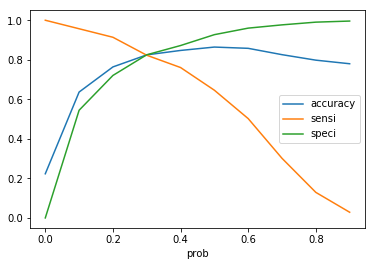

In [127]:
#using the previously defined function to identify the optimal threshold value
optimal_threshold(pred_final)

**Analysis**

Based on the graph we can see that 0.2 would give us a high sensitivity score but that would after the accuracy and specificity score which would still not be ideal. The optimal value should be where all of them would be more or less equal and above 80%. This is approximately at 0.3. 

In [128]:
confusion = predictions2(pred_final,0.3)

Confusion Matrix 
 [[600 127]
 [ 37 172]]


In [129]:
metrics(confusion,pred_final)

Accuracy:  0.8247863247863247
Specificity:  0.8253094910591472
Sensitivity: 0.8229665071770335


**Evaluation**

The 3 different metrics are about 80% and are all more or less the same. While sensitivity is out priority metric, accuracy and specificity are also important and at 0.3 threshold they all do well. 

**ROC Curve** 

In [130]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [131]:
fpr, tpr, thresholds = roc_curve( pred_final.churn, pred_final.Churn_Prob, drop_intermediate = False )

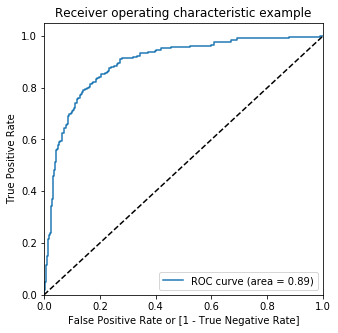

In [132]:
draw_roc(pred_final.churn, pred_final.Churn_Prob)

**Analysis**

The ROC curve area is as high as 0.89, which is a good indicator. It also is more skewed towards the y-axis which again is a good indicator that that the true positive rate is higher as compared to the False Positive Rate.

This graph further supports the Logistic Regression model made. It will be profitable for the business since clearly the True Positive Rate will correctly predict the possible churners without the business wasting money on non-churner (low false positive rate)

<hr>

<a id='recommendation'></a>

## Strategy to Prevent Churn: 

<hr>
The Churn that we have worked upon is "Usage-based churn" <br>
Basis the analysis and modelling, we have identified a list of potential 12 features that are responsible for churn,<br>
This is post doing PCA, followed by using Linear Regression(best fit model) using a combination of RFE with 20 as a cut off,<br> 
This was followed by Manual Logistic Regression and elimination of features using Coefficient Significance, P value Score and VIF.

<br><font face = tahoma, color = maroon>
Following are the 12 the features:
1. arpu_7 :			    Average revenue for a user for the 7th month
2. onnet_mou_6 :		All kind of calls with the same operator n/w and the minutes of usage for 6th month
3. onnet_mou_8 :		All kind of calls with the same operator n/w and the minutes of usage for 8th month
4. loc_og_mou_6 : 		local calls within the same telecom circle for 6th month
5. loc_og_mou_8 : 		local calls within the same telecom circle for 8th month
6. spl_og_mou_8 :		Special outgoing minutes of usage voice call for 8th month
7. total_ic_mou_6 :		Total incoming calls in 6th month
8. total_ic_mou_8 :		Total incoming calls in 8th month
9. total_rech_num_8 :   Total recharge number for 8th month
10. last_day_rch_amt_8 : All kind of calls with the same operator n/w and the minutes of usage for 8th month
11. vol_2g_mb_8	: 		Volume 2g in mb
12. vol_3g_mb_8	: 		Volume 3g in mb
</font>

**Action Plan 1** : 
<br><font face = tahoma, color = maroon>
We can clearly see that most of these features are for the 8th month, which can also be termed as the "Action Phase". <br>
These features are: last_day_rch_amt_8, vol_3g_mb_8, vol_2g_mb_8, spl_og_mou_8, total_ic_mou_8, onnet_mou_8, loc_og_mou_8 <br>
Some of these like are related like : loc_og_mou_8 and spl_og_mou_8 [local and special outgoing call minutes of usage] <br>
<hr>
Every month the following should be done:
    
1.1 For each of these 8th month features, we need to have a quarterly average value for the last 3 months - Let this be denoted by "Avg3month" <br>
1.2 Now compare current month's value with this "Avg3month" for each of these features ... <br>
1.3 If the current month's value for each of these features or most of these features happens to be lesser than 20% of "Avg3month" value <br>
1.4 Then it is a cause of concern and It should lead us to more deep dive of each of these features where their value if less than the respective ""Avg3month" for that feature. <br>
1.5 This should then be followed by an executive calling up those customers and enquiring about the usage of these identified features and a CSAT survey on the same. <br>
1.6 Corrective action can then be taken basis the feedback received. <br>
</font><hr>

**Action Plan 2** : 
<br><font face = tahoma, color = maroon>
arpu_7 <hr>
2.1 Average Revenue for 7th month is realized at the start of the 8th month. <br>
2.2 As such if we see a dip in arpu values in the current month as compared to the previous month and if this dip is beyond a defined threshold then again it is a cause of concern. <br>
2.3 Here as well, we can have Average value of ARPU for the past 3 months - let's refer to this as "Avg3monthARPU" <br>
2.4 Every month compare the previous month ARPU (realized this month) with "Avg3monthARPU" <br>
2.5 If the value is less than 20% of "Avg3monthARPU", then do a deep dive of all features identified in our churn exercise. <br>
2.6 Follow it up with a customer call to understand his/her outlook on the service provided for each of these identified features and accordingly take proactive corrective action
</font>